In [14]:
import gudhi as gd
import numpy as np
import torch
from scipy.spatial import Delaunay
from gudhi import AlphaComplex
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [15]:
# open .pt image tensor
heatmaps = torch.load('data/anotated_MNIST/heatmaps/heatmaps_01.pt')
# open .pt label tensor
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
# open .pt image tensor
images = torch.load('data/anotated_MNIST/raw/images_01.pt')

In [16]:
cropped_images = []
for i in tqdm(range(len(heatmaps))):
    # find min and max x,y values of the heap that are not 0
    heat = heatmaps[i].squeeze().numpy()
    image = images[i].squeeze().numpy()

    for i in range(heat.shape[0]):
        if sum(heat[i]) > 100:
            min_x = i
            break
    for i in range(heat.shape[0]-1, 0, -1):
        if sum(heat[i]) > 100:
            max_x = i
            break
    for i in range(heat.shape[1]):
        if sum(heat[:,i]) > 100:
            min_y = i
            break
    for i in range(heat.shape[1]-1, 0, -1):
        if sum(heat[:,i]) > 100:
            max_y = i
            break

    bouding_box = (min_x, max_x, min_y, max_y)
    # crop image based on bounding box
    cropped_image = image[min_x:max_x, min_y:max_y]

    cropped_images.append(cropped_image)

# reshape to 40x40 images
cropped_images_reshaped = []
for i in range(len(cropped_images)):
    cropped_images_reshaped.append(cv2.resize(cropped_images[i], (40, 40)))
cropped_images_reshaped = np.array(cropped_images_reshaped)

all_features = []
X = []
Y = []
for i in tqdm(range(len(cropped_images_reshaped))):
    threshold = 1.4
    example = cropped_images_reshaped[i]
    label = labels[i]
    # for each treshold do a deluneay triangulation and count the number of triangles
    # if the number of triangles is less than 1000 then the threshold is too low
    # if the number of triangles is more than 1000 then the threshold is too high
    # if the number of triangles is 1000 then the threshold is just right
    points = []
    y = 0
    for row in example:
        x = 0
        for el in row:
            points.append(np.array([[x, y], el]))
            x += 1
        y += 1
    # drop points with activation less than threshold
    points = np.array(points)
    points_cropped = points[points[:,1].astype(float) > threshold]
    points_cropped = list(map(lambda x: x, points_cropped[:,0]))
    tri = Delaunay(points_cropped)
    
    ac = AlphaComplex(points_cropped)

    ac.create_simplex_tree(max_alpha_square=2.0)

    st = ac.create_simplex_tree(max_alpha_square=2.0)

    diagram = st.persistence()
    X.append(diagram)
    Y.append(label)

  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/5l/_0j09j5n0gg7s_98h1l1nvw40000gn/T/ipykernel_3845/3456869107.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points.append(np.array([[x, y], el]))
100%|██████████| 300/300 [00:01<00:00, 163.17it/s]


In [ ]:
for idx in range(len(X)):
    if Y[idx] == 4:
        gd.plot_persistence_diagram(X[idx], legend = True)
        plt.title(f"Persisence Diagram with Label: {Y[idx]}")

In [42]:
class PDPrototypeClassifier:
    def __init__(self, num_classes, num_prototypes_per_class, pd_dim):
        self.num_classes = num_classes
        self.num_prototypes_per_class = num_prototypes_per_class
        self.pd_dim = pd_dim
        self.prototypes = None
        
    def fit(self, X, y):
        # Convert X (list of PDs) and y (list of labels) into a list of lists of PDs
        pd_lists = [[] for _ in range(self.num_classes)]
        for i in range(len(X)):
            pd_lists[y[i]].append(X[i])
        
        # Calculate prototypes for each class
        self.prototypes = [[] for _ in range(self.num_classes)]
        for c in range(self.num_classes):
            if len(pd_lists[c]) == 0:
                # No examples for this class, set prototypes to None
                self.prototypes[c] = None
            else:
                # Calculate prototypes by averaging the PDs
                pd_arrays = [print(pd) for pd in pd_lists[c]]
                prototypes = []
                for i in range(self.num_prototypes_per_class):
                    if len(pd_arrays) == 1:
                        prototypes.append(pd_arrays[0])
                    else:
                        weights = np.random.dirichlet(np.ones(len(pd_arrays)))
                        pd_sum = np.sum([weights[j] * pd_arrays[j] for j in range(len(pd_arrays))], axis=0)
                        prototypes.append(pd_sum / np.sum(weights))
                self.prototypes[c] = prototypes

    def predict(self, X):
        y_pred = []
        for x in X:
            # Calculate similarity scores for each class
            scores = np.zeros(self.num_classes)
            for c in range(self.num_classes):
                if self.prototypes[c] is None:
                    scores[c] = -np.inf
                else:
                    pd_array = gd.persistence_diagram(np.asarray(x))[:, :self.pd_dim]
                    distances = np.linalg.norm(self.prototypes[c] - pd_array, axis=(1,2))
                    scores[c] = -np.sum(np.sort(-distances)[:self.num_prototypes_per_class])
            # Predict class with highest similarity score
            y_pred.append(np.argmax(scores))
        return y_pred

In [43]:
# import train_test_split
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [44]:
# Create classifier
classifier = PDPrototypeClassifier(num_classes=10, num_prototypes_per_class=1, pd_dim=2)

# Fit classifier
classifier.fit(X_train, y_train)

# Predict on test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = np.sum(np.array(y_pred) == np.array(y_test)) / len(y_test)
print(f"Accuracy: {accuracy}")

# calculate ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[(1, (2.0, inf)), (1, (2.0, inf)), (1, (1.0, inf)), (1, (0.25, 1.0)), (1, (0.5, 1.25)), (1, (1.0, 1.5625)), (1, (0.5, 1.0)), (1, (1.25, 1.5625)), (1, (1.25, 1.5625)), (1, (1.25, 1.5625)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1, (0.25, 0.5)), (1

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [11]:
import torch
import torch.nn as nn

class PartialPrototypeLayer(nn.Module):
    def __init__(self, num_prototypes, num_channels, num_points, mask_size):
        super(PartialPrototypeLayer, self).__init__()
        self.num_prototypes = num_prototypes
        self.num_channels = num_channels
        self.num_points = num_points
        self.mask_size = mask_size
        self.prototype_layer = nn.Linear(num_channels*num_points, num_prototypes*num_points)

    def forward(self, x, prototypes):
        # x has shape (batch_size, num_channels, num_points)
        # prototypes has shape (num_prototypes, num_channels, num_points)
        
        # Apply mask to the input x
        # Note: we assume that the mask is centered on the middle point
        # of the input (i.e., point number (num_points-1)/2)
        mask = torch.ones(x.shape[-1])
        mask[:self.mask_size] = 0
        mask[-self.mask_size:] = 0
        mask = mask.to(x.device)
        masked_x = x * mask.unsqueeze(0).unsqueeze(0)
        
        # Flatten the input and the prototypes
        flat_x = masked_x.view(masked_x.shape[0], -1)  # shape: (batch_size, num_channels*num_points)
        flat_prototypes = prototypes.view(-1, self.num_channels*self.num_points)  # shape: (num_prototypes, num_channels*num_points)
        
        # Compute L2 distances between the input and the prototypes
        distances = torch.norm(flat_x.unsqueeze(1) - flat_prototypes.unsqueeze(0), dim=-1)  # shape: (batch_size, num_prototypes)
        
        # Take softmax to get similarity scores
        sim_scores = torch.softmax(-distances, dim=1)  # shape: (batch_size, num_prototypes)
        
        # Multiply the similarity scores with the prototype persistence diagrams
        # Note: here we only take the persistence diagrams of the first `mask_size` points
        masked_prototypes = prototypes[:, :, :self.mask_size]
        persistence_diagrams = masked_prototypes.sum(dim=2)  # shape: (num_prototypes, num_channels)
        weighted_persistence_diagrams = sim_scores.unsqueeze(-1) * persistence_diagrams.unsqueeze(0)  # shape: (batch_size, num_prototypes, num_channels)
        print(weighted_persistence_diagrams)
        # Sum up the weighted persistence diagrams to get the output
        output = weighted_persistence_diagrams.sum(dim=1)  # shape: (batch_size, num_channels)
        
        return output

tensor([[[0.3025],
         [0.3099],
         [0.2852],
         [0.2603],
         [0.3387]]], dtype=torch.float64)
Input shape: torch.Size([1, 1, 10])
Output shape: torch.Size([1, 1])


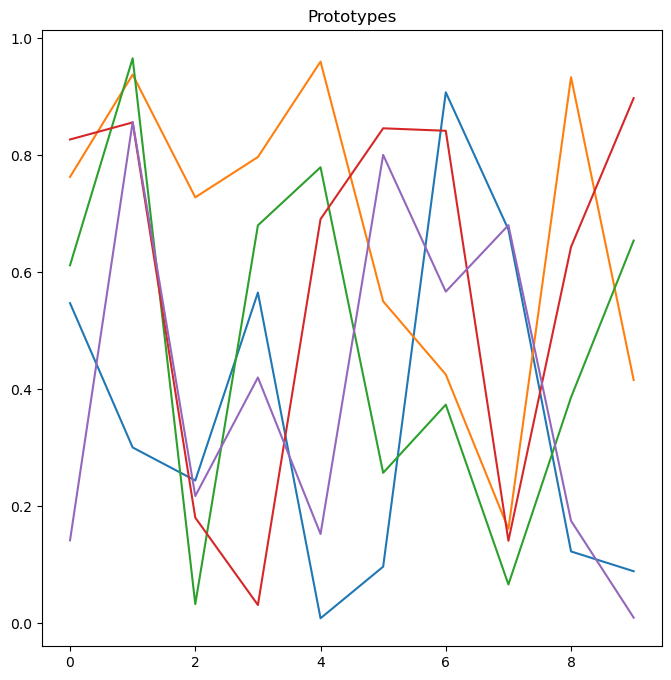

tensor([[1.4966]], dtype=torch.float64)

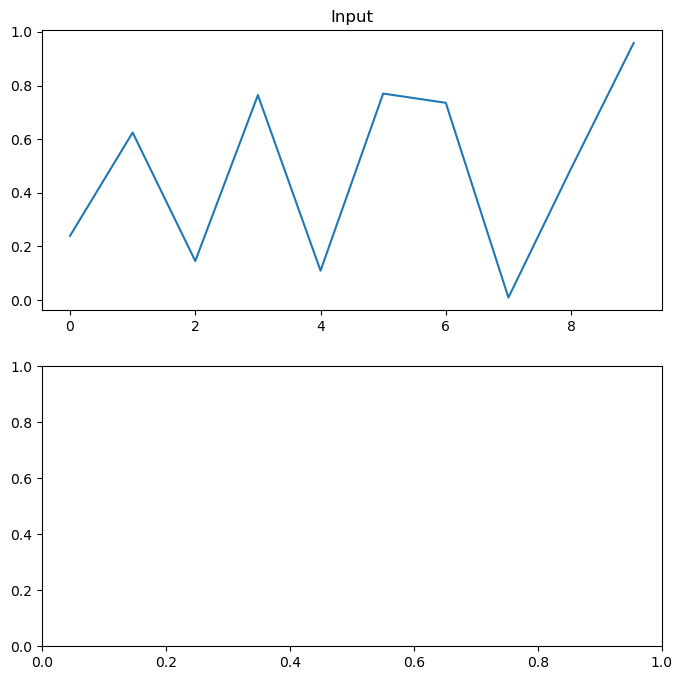

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create some dummy input and prototype data
batch_size = 1
num_channels = 1
num_points = 10
num_prototypes = 5
mask_size = 3

x = torch.tensor(np.random.rand(batch_size, num_channels, num_points))
prototypes = torch.tensor(np.random.rand(num_prototypes, num_channels, num_points))

# Create the partial prototype layer
partial_proto_layer = PartialPrototypeLayer(num_prototypes, num_channels, num_points, mask_size)

# Compute the output of the layer
output = partial_proto_layer(x, prototypes)

# Print the shapes of the input and output
print('Input shape:', x.shape)
print('Output shape:', output.shape)

# plot prototypes
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(num_prototypes):
    axs.plot(prototypes[i].T)
axs.set_title('Prototypes')
plt.show()
# Plot the input and output for the first batch item
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(x[0].T)
axs[0].set_title('Input')
output